# OpenML in Python 
OpenML is an online collaboration platform for machine learning: 

* Share/reuse machine learning datasets, algorithms, models, experiments
* Well documented/annotated datasets, uniform access
* APIs in Java, R, Python\*,... to download/upload everything
* Better reproducibility of experiments, reuse of machine learning models 
* Works well with machine learning libraries such as scikit-learn
* Large scale benchmarking, compare to state of the art

In [1]:
# General imports and settings
from preamble import *
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Authentication

* Create a (free) OpenML account on http://www.openml.org. 
* After logging in, open your account page (avatar on the top right)
* Open 'Account Settings', then 'API authentication' to find your API key.

There are two ways to authenticate:  

* Create a plain text file `~/.openml/config` with the line 'apikey=MYKEY', replacing MYKEY with your API key.
* Run the code below, replacing 'MYKEY' with your API key.

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key. 
# oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

# Data sets
We can list, select, and download all OpenML datasets

### List datasets

In [3]:
datalist = oml.datasets.list_datasets() # Returns a dict
datalist = pd.DataFrame.from_dict(datalist, orient='index') # Create a DataFrame
print("First 10 of %s datasets..." % len(datalist))
datalist[:10][['did','name','NumberOfInstances',
               'NumberOfFeatures','NumberOfClasses']]

First 10 of 19527 datasets...


,did,name,NumberOfInstances,NumberOfFeatures,NumberOfClasses
1,1,anneal,898.0,39.0,6.0
2,2,anneal,898.0,39.0,6.0
3,3,kr-vs-kp,3196.0,37.0,2.0
4,4,labor,57.0,17.0,2.0
5,5,arrhythmia,452.0,280.0,16.0
6,6,letter,20000.0,17.0,26.0
7,7,audiology,226.0,70.0,24.0
8,8,liver-disorders,345.0,7.0,-1.0
9,9,autos,205.0,26.0,7.0
10,10,lymph,148.0,19.0,4.0


There are many properties that we can query

In [4]:
list(datalist)
datalist = datalist[['did','name','NumberOfInstances',
               'NumberOfFeatures','NumberOfClasses']]

['NumberOfSymbolicFeatures',
 'MinorityClassSize',
 'NumberOfNumericFeatures',
 'NumberOfMissingValues',
 'NumberOfInstancesWithMissingValues',
 'MajorityClassSize',
 'status',
 'NumberOfClasses',
 'did',
 'format',
 'NumberOfFeatures',
 'NumberOfInstances',
 'name',
 'MaxNominalAttDistinctValues']

and we can filter or sort on all of them

In [5]:
datalist[datalist.NumberOfInstances>10000
        ].sort(['NumberOfInstances'])[:20]

,did,name,NumberOfInstances,NumberOfFeatures,NumberOfClasses
23515,23515,sulfur,10081.0,7.0,-1.0
372,372,internet_usage,10108.0,72.0,46.0
981,981,kdd_internet_usage,10108.0,69.0,2.0
1536,1536,volcanoes-b6,10130.0,4.0,5.0
4562,4562,InternetUsage,10168.0,72.0,-1.0
1531,1531,volcanoes-b1,10176.0,4.0,5.0
1534,1534,volcanoes-b4,10190.0,4.0,5.0
1459,1459,artificial-characters,10218.0,8.0,10.0
1478,1478,har,10299.0,562.0,6.0
1533,1533,volcanoes-b3,10386.0,4.0,5.0


or find specific ones

In [6]:
datalist.query('name == "eeg-eye-state"')

,did,name,NumberOfInstances,NumberOfFeatures,NumberOfClasses
1471,1471,eeg-eye-state,14980.0,15.0,2.0


In [7]:
datalist.query('NumberOfClasses > 50')

,did,name,NumberOfInstances,NumberOfFeatures,NumberOfClasses
1491,1491,one-hundred-plants-margin,1600.0,65.0,100.0
1492,1492,one-hundred-plants-shape,1600.0,65.0,100.0
1493,1493,one-hundred-plants-texture,1599.0,65.0,100.0
4546,4546,Plants,44940.0,16.0,57.0
4552,4552,BachChoralHarmony,5665.0,17.0,102.0


Download a specific dataset. This is done based on the dataset ID (called 'did').

In [8]:
dataset = oml.datasets.get_dataset(1471)

print("This is dataset '%s', the target feature is '%s'" % 
      (dataset.name, dataset.default_target_attribute))
print("URL: %s" % dataset.url)
print(dataset.description[:500])

This is dataset 'eeg-eye-state', the target feature is 'Class'
URL: https://www.openml.org/data/download/1587924/phplE7q6h
**Author**: Oliver Roesler, it12148'@'lehre.dhbw-stuttgart.de  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State), Baden-Wuerttemberg, Cooperative State University (DHBW), Stuttgart, Germany  
**Please cite**:   

All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video fr


Convert the data to a DataFrame for easier processing/plotting

In [9]:
X, y, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute, 
    return_attribute_names=True)
eeg = pd.DataFrame(X, columns=attribute_names)
eeg['class'] = y
print(eeg[:10])

        V1       V2       V3       V4  ...        V12      V13      V14  class
0  4329.23  4009.23  4289.23  4148.21  ...    4280.51  4635.90  4393.85      0
1  4324.62  4004.62  4293.85  4148.72  ...    4279.49  4632.82  4384.10      0
2  4327.69  4006.67  4295.38  4156.41  ...    4282.05  4628.72  4389.23      0
3  4328.72  4011.79  4296.41  4155.90  ...    4287.69  4632.31  4396.41      0
4  4326.15  4011.79  4292.31  4151.28  ...    4288.21  4632.82  4398.46      0
5  4321.03  4004.62  4284.10  4153.33  ...    4281.03  4628.21  4389.74      0
6  4319.49  4001.03  4280.51  4151.79  ...    4269.74  4625.13  4378.46      0
7  4325.64  4006.67  4278.46  4143.08  ...    4266.67  4622.05  4380.51      0
8  4326.15  4010.77  4276.41  4139.49  ...    4273.85  4627.18  4389.74      0
9  4326.15  4011.28  4276.92  4142.05  ...    4277.95  4637.44  4393.33      0

[10 rows x 15 columns]


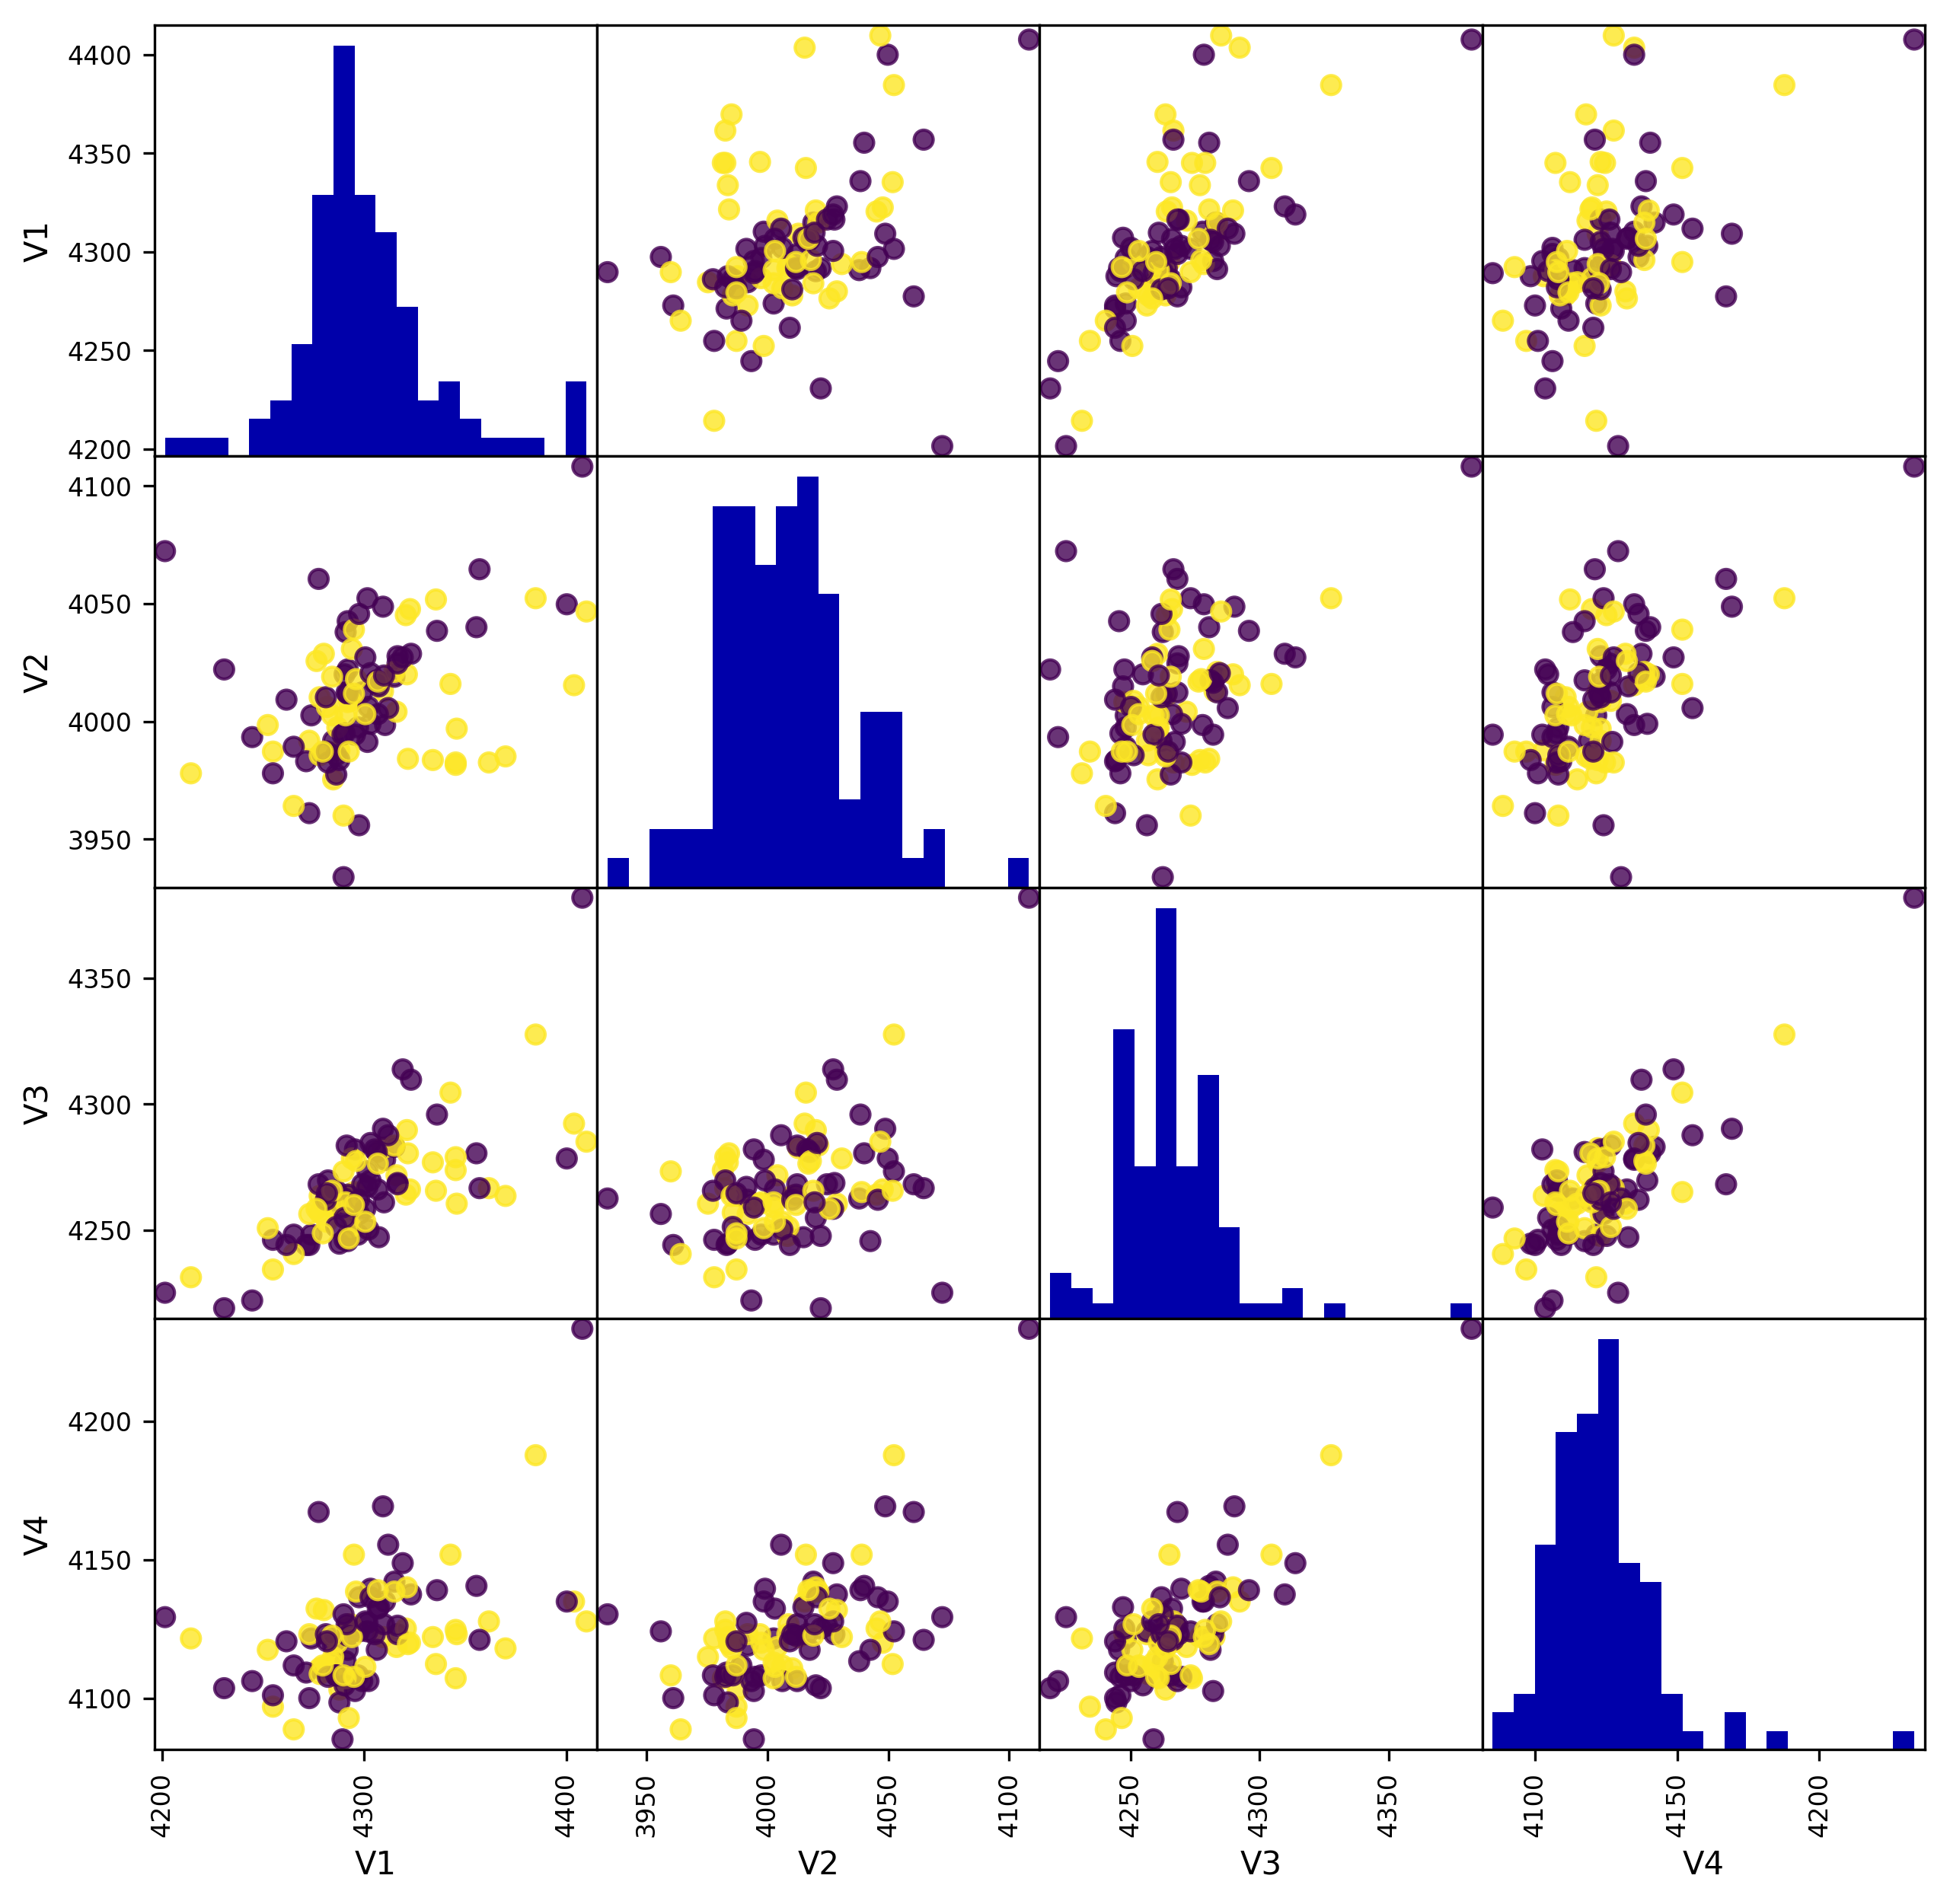

In [10]:
eegs = eeg.sample(n=1000)
_ = pd.scatter_matrix(eegs.iloc[:100,:4], c=eegs[:100]['class'], figsize=(10, 10), 
                  marker='o', hist_kwds={'bins': 20}, 
                  alpha=.8, cmap='viridis')

## Train models
Train a scikit-learn model on the data manually

In [11]:
from sklearn import neighbors

dataset = oml.datasets.get_dataset(1471)
X, y = dataset.get_data(target=dataset.default_target_attribute)
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

You can also ask which features are categorical to do your own encoding

In [12]:
from sklearn import preprocessing
dataset = oml.datasets.get_dataset(10)
X, y, categorical = dataset.get_data(
    target=dataset.default_target_attribute,
    return_categorical_indicator=True)
print("Categorical features: %s" % categorical)
enc = preprocessing.OneHotEncoder(categorical_features=categorical)
X = enc.fit_transform(X)
clf.fit(X, y)

Categorical features: [True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, False]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

# Tasks

To compar models consistently (across studies and tools), OpenML offers Tasks, which include specific train-test splits and other information to define a scientific task. Tasks are typically created via the website by the dataset provider.

## Listing tasks

In [22]:
task_list = oml.tasks.list_tasks(size=5000) # Get first 5000 tasks

mytasks = pd.DataFrame(task_list).transpose()
print("First 5 of %s tasks:" % len(mytasks))

First 5 of 4998 tasks:


In [14]:
mytasks = mytasks[['tid','did','name','task_type','estimation_procedure','evaluation_measures']]
print(mytasks.head())

  tid did        name                  task_type     estimation_procedure  \
1   1   1      anneal  Supervised Classification  10-fold Crossvalidation   
2   2   2      anneal  Supervised Classification  10-fold Crossvalidation   
3   3   3    kr-vs-kp  Supervised Classification  10-fold Crossvalidation   
4   4   4       labor  Supervised Classification  10-fold Crossvalidation   
5   5   5  arrhythmia  Supervised Classification  10-fold Crossvalidation   

   evaluation_measures  
1  predictive_accuracy  
2  predictive_accuracy  
3  predictive_accuracy  
4  predictive_accuracy  
5  predictive_accuracy  


Search for the tasks you need

In [15]:
print(mytasks.query('name=="eeg-eye-state"'))

         tid   did           name                  task_type  \
9983    9983  1471  eeg-eye-state  Supervised Classification   
14951  14951  1471  eeg-eye-state  Supervised Classification   

          estimation_procedure  evaluation_measures  
9983   10-fold Crossvalidation  predictive_accuracy  
14951  10-fold Crossvalidation                  NaN  


## Download tasks

In [16]:
task = oml.tasks.get_task(14951)
pprint(vars(task))

{'class_labels': ['1', '2'],
 'cost_matrix': None,
 'dataset_id': 1471,
 'estimation_parameters': {'number_folds': '10',
                           'number_repeats': '1',
                           'percentage': '',
                           'stratified_sampling': 'true'},
 'estimation_procedure': {'data_splits_url': 'https://www.openml.org/api_splits/get/14951/Task_14951_splits.arff',
                          'parameters': {'number_folds': '10',
                                         'number_repeats': '1',
                                         'percentage': '',
                                         'stratified_sampling': 'true'},
                          'type': 'crossvalidation'},
 'evaluation_measure': None,
 'target_name': 'Class',
 'task_id': 14951,
 'task_type': 'Supervised Classification'}


# Runs: Train models on tasks
We can run (many) scikit-learn algorithms on (many) OpenML tasks.

In [17]:
task = oml.tasks.get_task(14951)
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
run = oml.runs.run_task(task, clf)
run.model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Share the run on the OpenML server

In [18]:
myrun = run.publish()
print("Uploaded to http://www.openml.org/r/" + str(myrun.run_id))

Uploaded to http://www.openml.org/r/1849367


### It also works with pipelines

In [19]:
from sklearn import pipeline, ensemble, preprocessing
from openml import tasks,runs, datasets
task = tasks.get_task(59)
pipe = pipeline.Pipeline(steps=[
            ('Imputer', preprocessing.Imputer(strategy='median')),
            ('OneHotEncoder', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')),
            ('Classifier', ensemble.RandomForestClassifier())
           ])
run = runs.run_task(task, pipe)
myrun = run.publish()
print("Uploaded to http://www.openml.org/r/" + str(myrun.run_id))

Uploaded to http://www.openml.org/r/1849368


## All together
Train any model on any OpenML dataset and upload to OpenML in a few lines of code

In [20]:
from sklearn.linear_model import LogisticRegression

task = oml.tasks.get_task(145677)
clf = LogisticRegression()
run = oml.runs.run_task(task, clf)
run.model
myrun = run.publish()
print("Uploaded to http://www.openml.org/r/" + str(myrun.run_id))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Uploaded to http://www.openml.org/r/1849369


## A Challenge
We'll see many machine learning algorithms in this course. Try to build the best possible models on several OpenML tasks, and compare your results with the rest of the class, and learn from them. Some tasks you could try (or browse openml.org):

* EEG eye state: data_id:[1471](http://www.openml.org/d/1471), task_id:[14951](http://www.openml.org/t/14951)
* Mice protein: data_id:[4550](http://www.openml.org/d/4550), task_id:[34538](http://www.openml.org/t/34538), 1k instances, 80 features, missing values. Easy.
* Walking activity: data_id:[1509](http://www.openml.org/d/1509), task_id: [9945](http://www.openml.org/t/9945), 150k instances
* Thoracic_surgery: data_id:[4329](http://www.openml.org/d/4329), task_id: [145679](http://www.openml.org/t/145679). 0.5K instances, no missing values.
* Diabetes130US: data_id:[23512](http://www.openml.org/d/23512), task_id:[?](http://www.openml.org/t/?). 100k instances, missing values

Easy benchmarking:

In [21]:
import openml as oml
from sklearn import neighbors

for task_id in [14951,10103,9945]:
    task = oml.tasks.get_task(task_id)
    data = oml.datasets.get_dataset(task.dataset_id)
    clf = neighbors.KNeighborsClassifier(n_neighbors=5)
    run = oml.runs.run_task(task, clf)
    myrun = run.publish()
    print("kNN on %s: http://www.openml.org/r/%d" % (data.name, myrun.run_id))

kNN on eeg-eye-state: http://www.openml.org/r/1849370
kNN on volcanoes-a1: http://www.openml.org/r/1849371
kNN on walking-activity: http://www.openml.org/r/1849372


## Other possibilities
OpenML's Python API is currently still under development. To be added soon:

* Organizing data sets, algorithms, and experiments into studies
* Sharing data and expriments with circles of friends
* Downloading previous experiments, evaluations and models
* Uploading new datasets to OpenML via python
* Filters for listings (e.g. filter by author, tags, other properties)

All of this is already possible with the R and Java API.